**Predicting CO2 Emissions**

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

The objective of this exercise is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions.

These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.

**Acknowledgements**

We acknowledge Carbon Monitor for the use of the GRACED dataset, and special thanks Darius Moruri from Zindi for his work in preparing the dataset and starter notebooks

In [6]:
import numpy as np
import pandas as pd
import os
import re
import copy
import pickle
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
# import torch
# import torch.nn as nn
# import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

import plotly.express as px

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# import geopandas as gpd
# from shapely.geometry import Point
# import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


```markdown
## Data Cleaning and Transformation

The following section will include data cleaning and transforming of the data shape.
```

In [7]:
# Load the Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [8]:

train_df.head()
train_df.shape, test_df.shape

((79023, 76), (24353, 75))

In [9]:
# Check basic information of the datasets
print("Train Data Info:")
train_df.info()

print("\nTest Data Info:")
test_df.info()

# Check for missing values in both datasets
print("\nMissing Values in Train Data:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8  

In [10]:
total_missing = train_df.isnull().sum().sum()
total_entries = train_df.size
overall_missing_percentage = (total_missing / total_entries) * 100
overall_missing_percentage

16.4857233437034

In [11]:
# Statistical summary of numerical features
print("Train Data Statistics:")
display(train_df.describe())

print("\nTest Data Statistics:")
display(test_df.describe())


Train Data Statistics:


latitude   longitude        year     week_no  \
count 79023.00000 79023.00000 79023.00000 79023.00000   
mean     -1.89107    29.88015  2020.00000    26.00000   
std       0.69452     0.81038     0.81650    15.29716   
min      -3.29900    28.22800  2019.00000     0.00000   
25%      -2.45100    29.26200  2019.00000    13.00000   
50%      -1.88200    29.88300  2020.00000    26.00000   
75%      -1.30300    30.47100  2021.00000    39.00000   
max      -0.51000    31.53200  2021.00000    52.00000   

       SulphurDioxide_SO2_column_number_density  \
count                               64414.00000   
mean                                    0.00005   
std                                     0.00027   
min                                    -0.00100   
25%                                    -0.00010   
50%                                     0.00002   
75%                                     0.00015   
max                                     0.00419   

       SulphurDioxide_SO2_column_number_density_amf  \
count                                   64414.00000   
mean                                        0.83485   
std                                         0.18538   
min                                         0.24182   
25%                                         0.70582   
50%                                         0.80912   
75%                                         0.94279   
max                                         1.88524   

       SulphurDioxide_SO2_slant_column_number_density  \
count                                     64414.00000   
mean                                          0.00004   
std                                           0.00021   
min                                          -0.00089   
25%                                          -0.00008   
50%                                           0.00002   
75%                                           0.00012   
max                                           0.00424   

       SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
count                    64414.00000                          64414.00000   
mean                         0.15842                             -7.92587   
std                          0.07136                             64.26337   
min                          0.00000                           -179.53706   
25%                          0.11053                            -56.78238   
50%                          0.16185                            -12.44173   
75%                          0.21182                             72.05999   
max                          0.30000                            122.09520   

       SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_height  \
count                         64414.00000  ...             78539.00000   
mean                             37.43619  ...              5592.37748   
std                              14.14995  ...              1428.50300   
min                               0.09924  ...              1050.66178   
25%                              28.84452  ...              4595.40052   
50%                              37.78430  ...              5573.85431   
75%                              47.63488  ...              6542.30364   
max                              66.24201  ...             12384.23946   

       Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
count                78539.00000              78539.00000   
mean                 59420.29746               4670.43087   
std                   9051.16361               1359.25158   
min                  24779.03370               1050.49682   
25%                  53175.77993               3680.85634   
50%                  59332.53255               4621.75517   
75%                  65663.84268               5572.98322   
max                  89291.61558              11384.23946   

       Cloud_cloud_optical_depth  Cloud_surface_albedo  \
count                78539.00000           78539.00000  


Test Data Statistics:


latitude   longitude        year     week_no  \
count 24353.00000 24353.00000 24353.00000 24353.00000   
mean     -1.89107    29.88015  2022.00000    24.00000   
std       0.69453     0.81039     0.00000    14.14243   
min      -3.29900    28.22800  2022.00000     0.00000   
25%      -2.45100    29.26200  2022.00000    12.00000   
50%      -1.88200    29.88300  2022.00000    24.00000   
75%      -1.30300    30.47100  2022.00000    36.00000   
max      -0.51000    31.53200  2022.00000    48.00000   

       SulphurDioxide_SO2_column_number_density  \
count                               18211.00000   
mean                                    0.00001   
std                                     0.00023   
min                                    -0.00098   
25%                                    -0.00012   
50%                                     0.00001   
75%                                     0.00014   
max                                     0.00411   

       SulphurDioxide_SO2_column_number_density_amf  \
count                                   18211.00000   
mean                                        0.79257   
std                                         0.16804   
min                                         0.33984   
25%                                         0.67838   
50%                                         0.76331   
75%                                         0.87259   
max                                         1.69683   

       SulphurDioxide_SO2_slant_column_number_density  \
count                                     18211.00000   
mean                                          0.00001   
std                                           0.00017   
min                                          -0.00077   
25%                                          -0.00009   
50%                                           0.00000   
75%                                           0.00010   
max                                           0.00270   

       SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
count                    18211.00000                          18211.00000   
mean                         0.13922                              9.29805   
std                          0.07986                             67.14820   
min                          0.00000                           -106.80990   
25%                          0.07893                            -41.62730   
50%                          0.13900                             16.85796   
75%                          0.20082                             73.66456   
max                          0.29997                            157.50303   

       SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_pressure  \
count                         18211.00000  ...               24187.00000   
mean                             36.17431  ...               52291.36982   
std                              14.15648  ...                8474.31213   
min                               0.09961  ...               22968.37109   
25%                              26.57765  ...               46443.51351   
50%                              37.31045  ...               52026.81465   
75%                              45.97259  ...               57814.50940   
max                              66.24327  ...               83092.00425   

       Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
count             24187.00000                24187.00000   
mean               5850.56088                58914.75064   
std                1385.45656                 9137.47885   
min                1748.44055                26601.01562   
25%                4891.54777                52564.91100   
50%                5813.01089                58725.29890   
75%                6780.09513                64998.47000   
max               11840.53974                88543.12146   

       Cloud_cloud_base_height  Cloud_cloud_optical_depth  \
count              24187.00000              

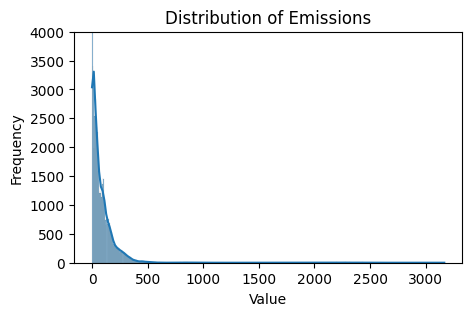

Skew:  10.173825825101622


In [12]:
# Let's check out the distribution of the data 
plt.figure(figsize=(5, 3))
sns.histplot(train_df['emission'], kde=True)
plt.title('Distribution of Emissions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim(0, 4000) 
plt.show()

print('Skew: ', train_df['emission'].skew()) # skewed to the right - we'll figure out how to handle this (if needed) while building our model

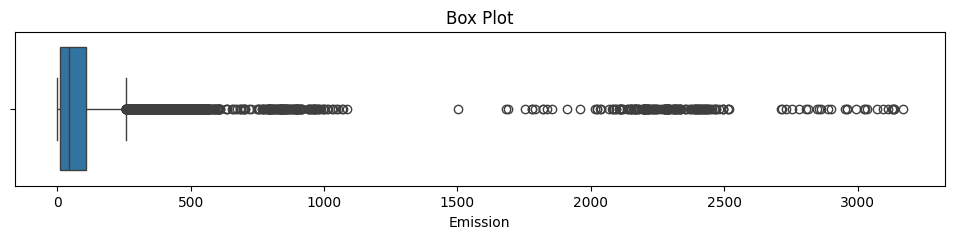

In [13]:
plt.figure(figsize=(12, 2))
sns.boxplot(x=train_df['emission'])
plt.title('Box Plot')
plt.xlabel('Emission')
plt.show()

# most of the emissions are below 500

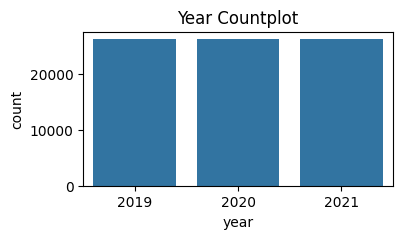

In [14]:
#now let's analyse this data as a timeseries

plt.figure(figsize=(4,2))
sns.countplot(x='year', data=train_df)
plt.title('Year Countplot')
plt.show()


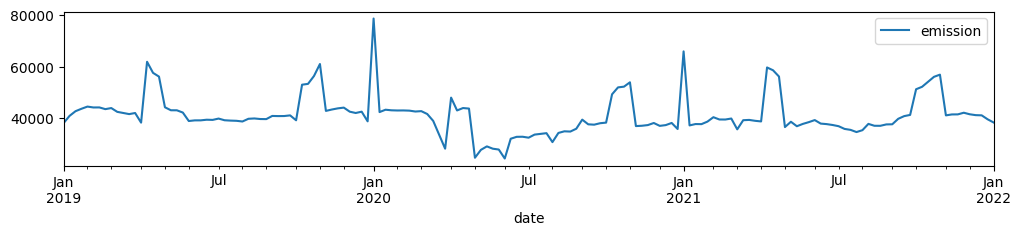

In [15]:
train_df['date'] = pd.to_datetime(train_df['year'].astype(str) + train_df['week_no'].astype(str) + '0', format='%Y%W%w')
weekly_emissions = train_df.groupby(['date'])[['emission']].sum()
weekly_emissions.plot(figsize=(12,2))
plt.show()

In [16]:
# List all columns in the train and test datasets
print("Train Data Columns:")
print(train_df.columns)

print("\nTest Data Columns:")
print(test_df.columns)

# 'CO2 Emissions' is the target
target_column = 'emission'  # Target column
feature_columns = [col for col in train_df.columns if col != target_column]

print("\nTarget Column:")
print(target_column)

print("\nFeature Columns:")
print(feature_columns)


Train Data Columns:
Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
   

Columns in train_df: Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
  

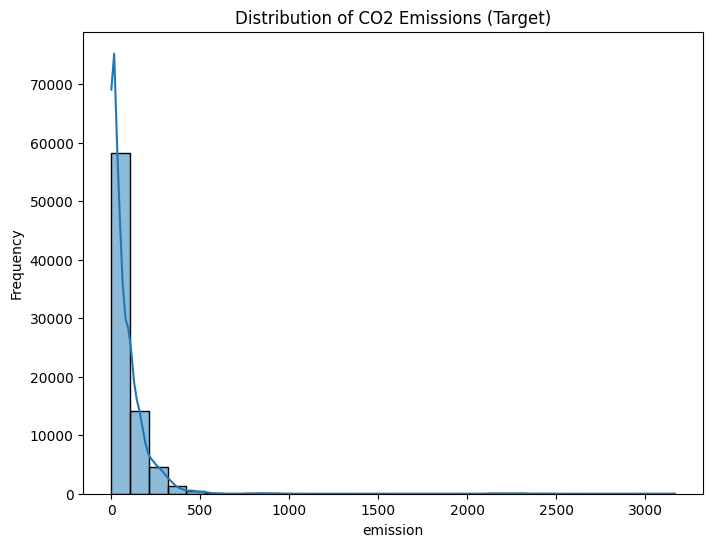

In [17]:
# Check the column names to ensure the target column exists
print("Columns in train_df:", train_df.columns)

# Verify the target column name
if target_column not in train_df.columns:
	print(f"Error: '{target_column}' column not found in train_df")
else:
	# Plot the distribution of the target variable
	plt.figure(figsize=(8, 6))
	sns.histplot(train_df[target_column], kde=True, bins=30)
	plt.title("Distribution of CO2 Emissions (Target)")
	plt.xlabel('emission')
	plt.ylabel("Frequency")
	plt.show()


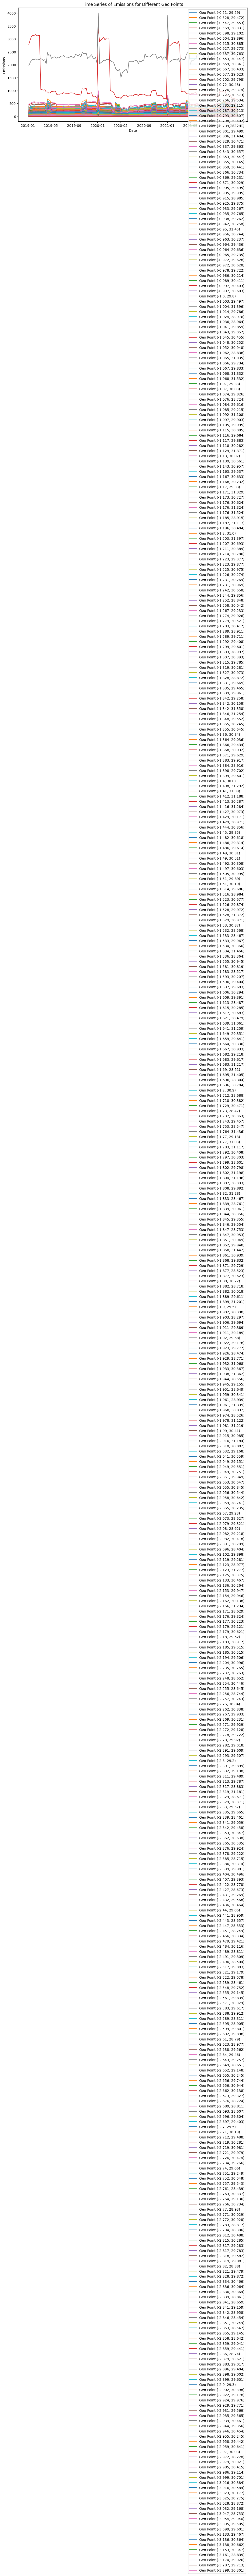

In [18]:
# Assuming 'latitude' and 'longitude' are the columns representing different geographical points
geo_points = train_df[['latitude', 'longitude']].drop_duplicates()

plt.figure(figsize=(12, 6))

for _, geo_point in geo_points.iterrows():
    geo_data = train_df[(train_df['latitude'] == geo_point['latitude']) & (train_df['longitude'] == geo_point['longitude'])]
    geo_data = geo_data.groupby('date')['emission'].sum()
    plt.plot(geo_data.index, geo_data.values, label=f'Geo Point ({geo_point["latitude"]}, {geo_point["longitude"]})')

plt.title('Time Series of Emissions for Different Geo Points')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.show()

                                                    latitude  longitude  \
latitude                                             1.00000    0.23951   
longitude                                            0.23951    1.00000   
year                                                -0.00000   -0.00000   
week_no                                              0.00000    0.00000   
SulphurDioxide_SO2_column_number_density             0.00351   -0.12966   
SulphurDioxide_SO2_column_number_density_amf         0.04501    0.08680   
SulphurDioxide_SO2_slant_column_number_density       0.00739   -0.13124   
SulphurDioxide_cloud_fraction                       -0.00839    0.02887   
SulphurDioxide_sensor_azimuth_angle                 -0.00488   -0.01262   
SulphurDioxide_sensor_zenith_angle                  -0.01390    0.01374   
SulphurDioxide_solar_azimuth_angle                  -0.03159   -0.03037   
SulphurDioxide_solar_zenith_angle                   -0.02029    0.00282   
SulphurDioxide_SO2_column

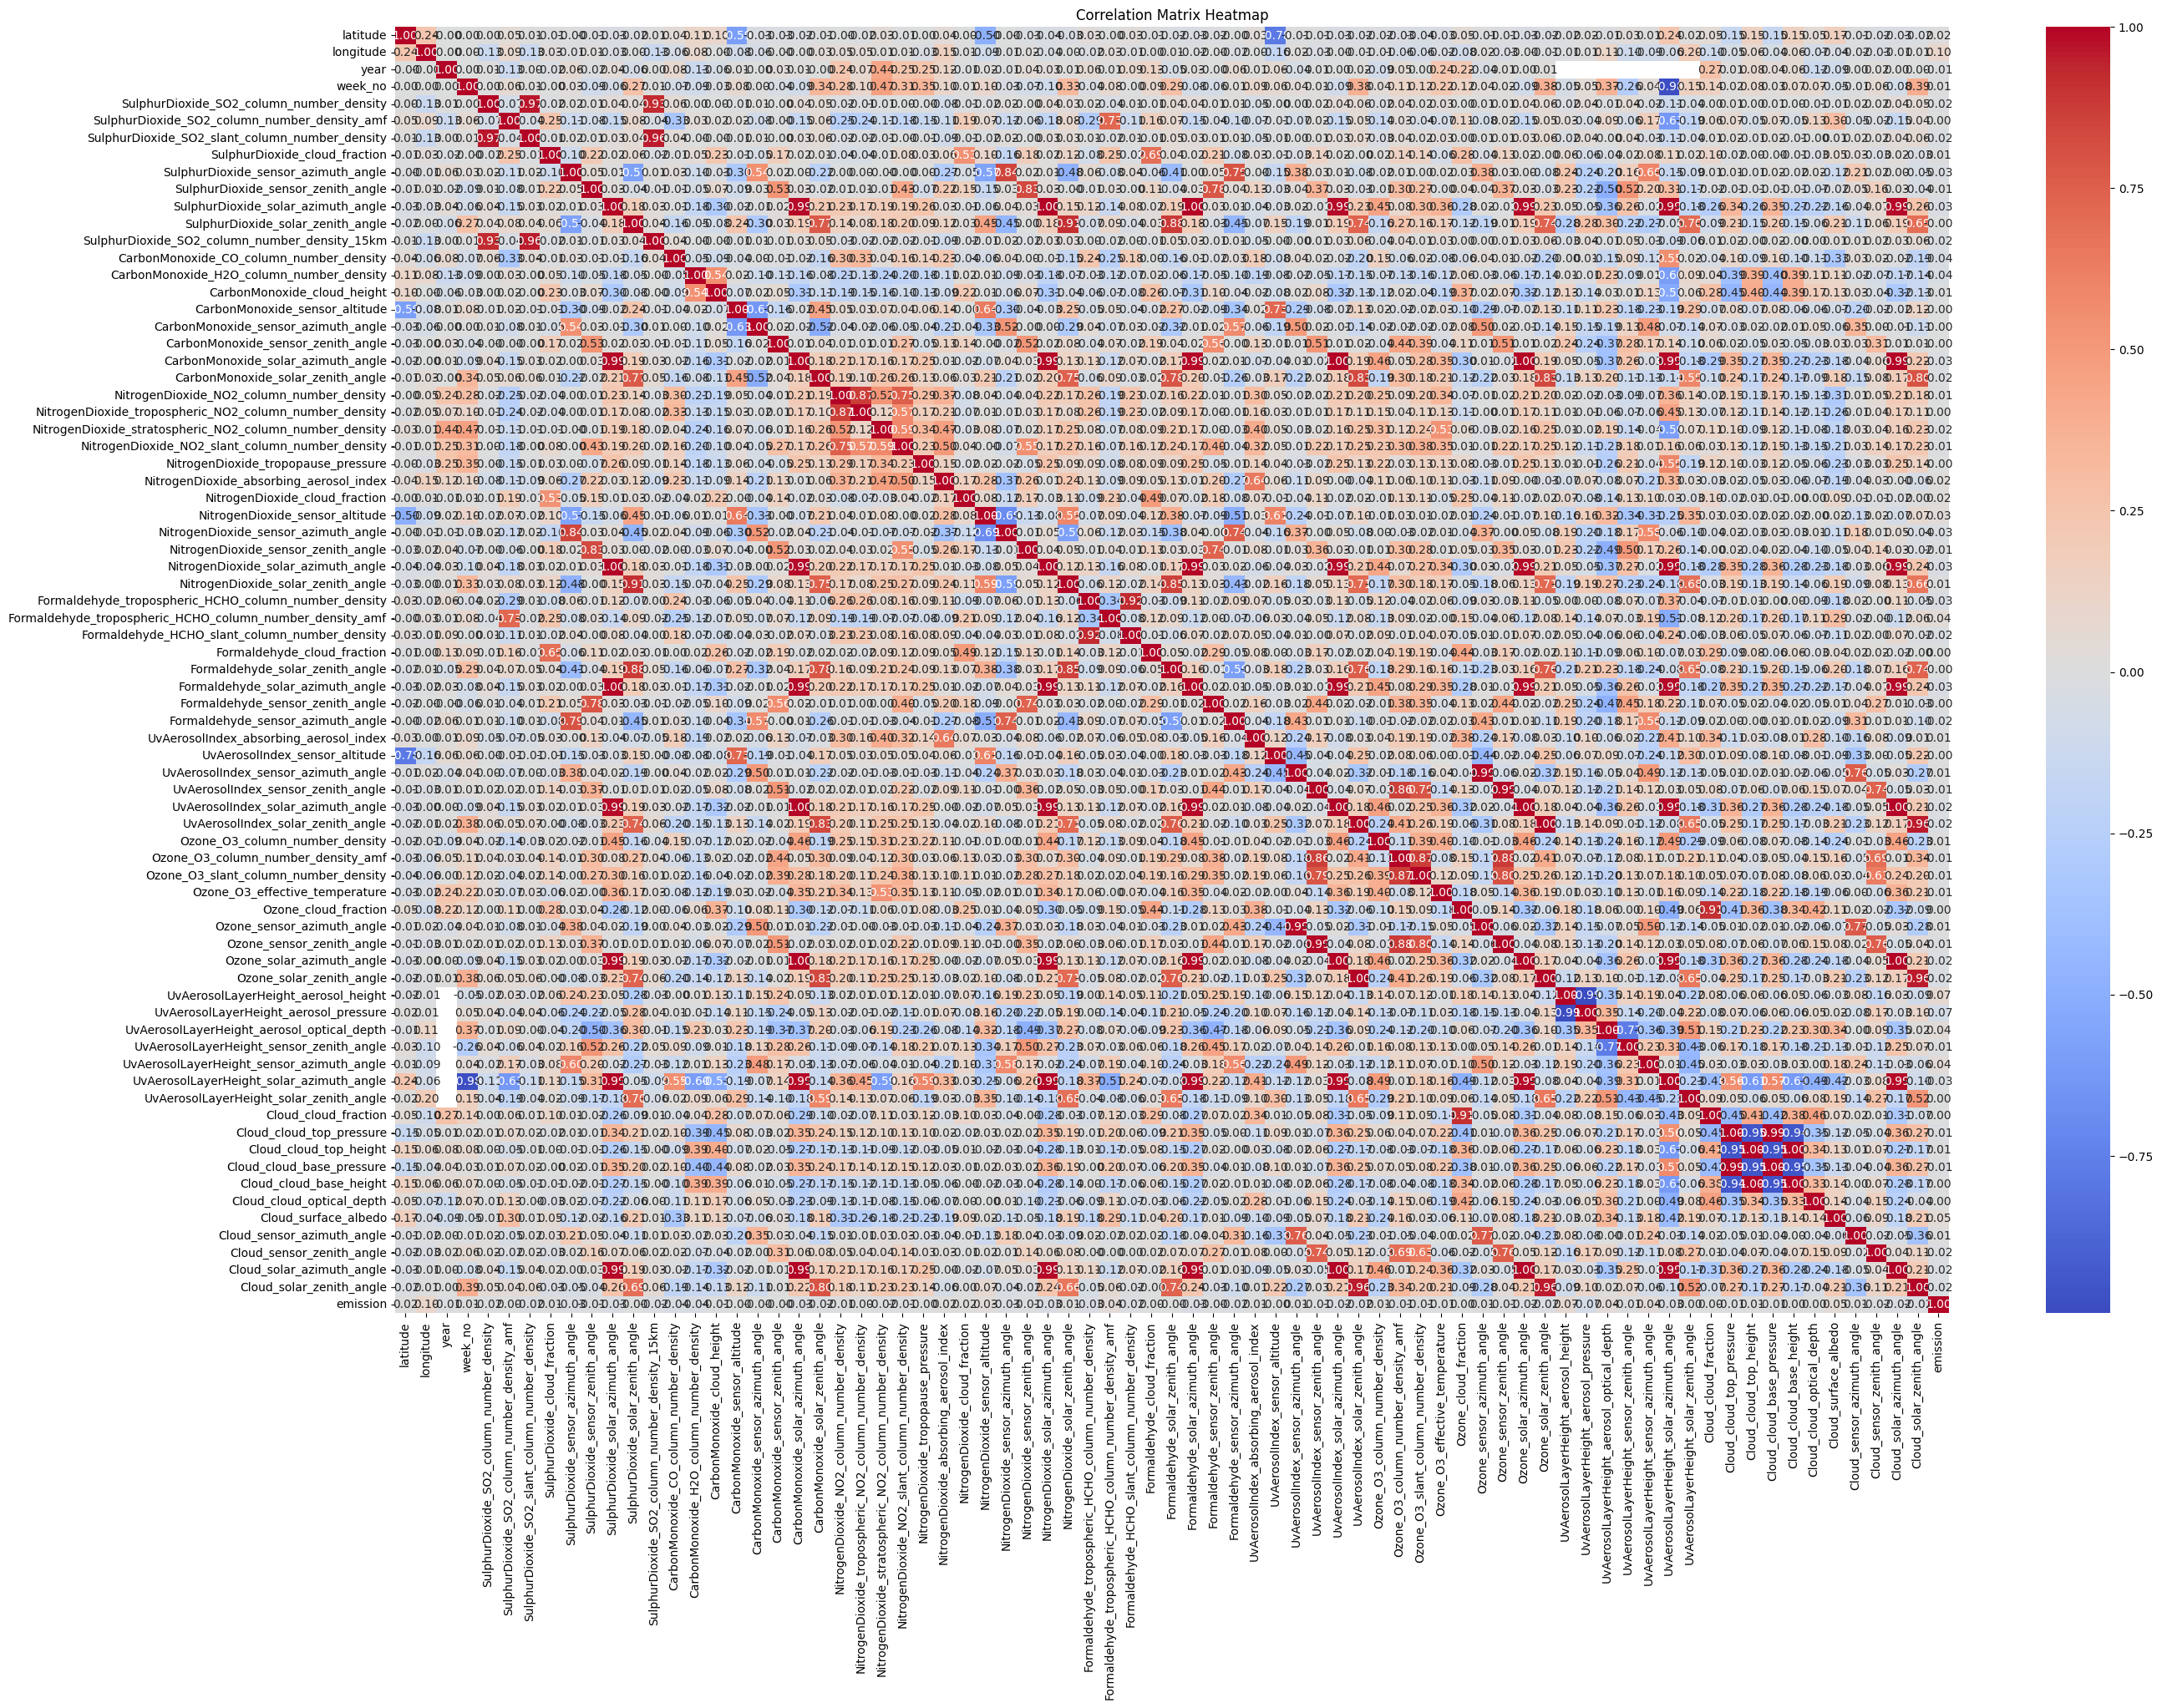

In [19]:
# Select only numeric columns
numeric_data = train_df.select_dtypes(include=[np.number])

# Calculate correlation
correlation_matrix = numeric_data.corr()
print(correlation_matrix)

# Optionally, you can visualize the correlation matrix using a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
# # Select only numeric columns
# numeric_data = train_df.select_dtypes(include=[np.number])

# # Calculate correlation
# correlation_matrix = numeric_data.corr()

# Extract correlation values of all features with the target variable
target_column = 'emission'  # Correct target column name
correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)

# Display the most correlated features
print("Features Correlated with Target (CO2 Emissions):")
print(correlation_with_target)

# Define a correlation threshold to select features (e.g., 0.3 or higher)
correlation_threshold = 0.3
selected_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold].index.tolist()

# # Remove the target column from the list of selected features
# if target_column in selected_features:
#     selected_features.remove(target_column)

# # Debugging: Check if selected_features is empty and print a message
# if not selected_features:
#     print("\nNo features meet the correlation threshold. Consider lowering the threshold or investigating the data.")

# print("\nSelected Features Based on Correlation Threshold:")
print(selected_features)


Features Correlated with Target (CO2 Emissions):
emission                                                    1.00000
longitude                                                   0.10275
UvAerosolLayerHeight_aerosol_height                         0.06901
Cloud_surface_albedo                                        0.04659
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.04026
UvAerosolLayerHeight_aerosol_optical_depth                  0.04016
UvAerosolLayerHeight_sensor_azimuth_angle                   0.03514
NitrogenDioxide_sensor_altitude                             0.02754
NitrogenDioxide_cloud_fraction                              0.02246
NitrogenDioxide_absorbing_aerosol_index                     0.02091
latitude                                                    0.01785
Ozone_O3_column_number_density                              0.01381
UvAerosolIndex_sensor_azimuth_angle                         0.00830
Ozone_sensor_azimuth_angle                                  0.00777

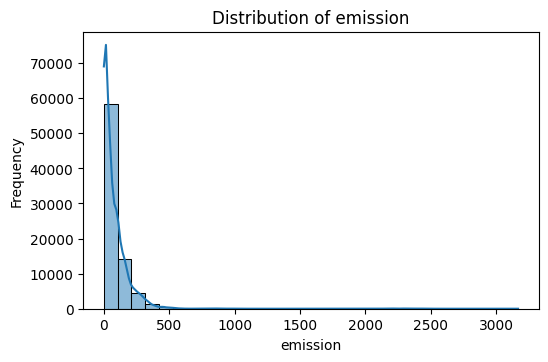

In [21]:
# Plot the distribution of each selected feature
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 3, i)  # Adjust grid size based on the number of features
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [33]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Handle Missing Values
# Using SimpleImputer for mean and median imputation
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

# Using KNNImputer for advanced imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values in train_df
train_df_imputed = train_df.copy()
for column in train_df_imputed.columns:
    if train_df_imputed[column].isnull().sum() > 0:
        if train_df_imputed[column].dtype == 'float64' or train_df_imputed[column].dtype == 'int64':
            train_df_imputed[column] = mean_imputer.fit_transform(train_df_imputed[[column]])
        else:
            train_df_imputed[column] = knn_imputer.fit_transform(train_df_imputed[[column]])

# Feature Engineering
# Adding time-based features
train_df_imputed['year'] = train_df_imputed['date'].dt.year
train_df_imputed['month'] = train_df_imputed['date'].dt.month
train_df_imputed['week'] = train_df_imputed['date'].dt.isocalendar().week

# Normalization/Scaling
scaler = StandardScaler()
numerical_features = train_df_imputed.select_dtypes(include=[np.number]).columns.tolist()
train_df_imputed[numerical_features] = scaler.fit_transform(train_df_imputed[numerical_features])

# Categorical Variables Encoding
categorical_features = train_df_imputed.select_dtypes(include=[object]).columns.tolist()
label_encoders = {}
for feature in categorical_features:
    encoder = LabelEncoder()
    train_df_imputed[feature] = encoder.fit_transform(train_df_imputed[feature])
    label_encoders[feature] = encoder

# Display the preprocessed DataFrame
print(train_df_imputed.head())

   ID_LAT_LON_YEAR_WEEK  latitude  longitude     year  week_no  \
0                     0   1.98853   -0.72825 -1.23088 -1.69967   
1                     1   1.98853   -0.72825 -1.23088 -1.63430   
2                     2   1.98853   -0.72825 -1.23088 -1.56893   
3                     3   1.98853   -0.72825 -1.23088 -1.50356   
4                     4   1.98853   -0.72825 -1.23088 -1.43818   

   SulphurDioxide_SO2_column_number_density  \
0                                  -0.61743   
1                                  -0.09311   
2                                   1.91527   
3                                  -0.08022   
4                                  -0.49710   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      -1.35430   
1                                      -0.60762   
2                                      -0.48842   
3                                      -0.12509   
4                                      -0.91726   

   SulphurDio